In [1]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skbio.stats.composition import clr, centralize
from scipy.spatial.distance import euclidean

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

First we will import the simulation data and the KL-divergence results with or without rclr preprocessing

In [2]:

#simulation view
simulation=pd.read_csv('cluster_models/simulation_subsampled_noisy.csv', index_col=[0,1,2,3])
model_100=simulation.loc[(2,20,100,),:]

#import and view results from simuilation
cluster_results=pd.read_csv('cluster_models/results.csv')
processing={2:'rclr',1:'Raw Counts'}
cluster_results['Proc']=[processing[len(x.split('rclr'))] for x in cluster_results.Method]
cluster_results['Method_']=[x.replace('rclr-','') for x in cluster_results.Method]
cluster_results_plot=cluster_results[cluster_results.Overlap.isin([20])]
cluster_results_plot=cluster_results_plot[cluster_results_plot.Method_.isin(['OptSpace'])]



Next we will generate a toy dataset example for Euclidean distance vs. Robust Aitchison
 

In [7]:

#toy
n = 50
t = np.linspace(1, 10, n)
x1 = np.exp(t) * 0.001
x2 = np.random.normal(size=n) + 100
x3 = np.random.normal(size=n) * 10 + 100
X = np.vstack((x1, x2, x3)).T
edists = [euclidean(X[0, :], X[i, :]) for i in range(X.shape[0])]
cdists = [euclidean(clr(X[0, :]), clr(X[i, :])) for i in range(X.shape[0])]


Now we will plot figure 2!

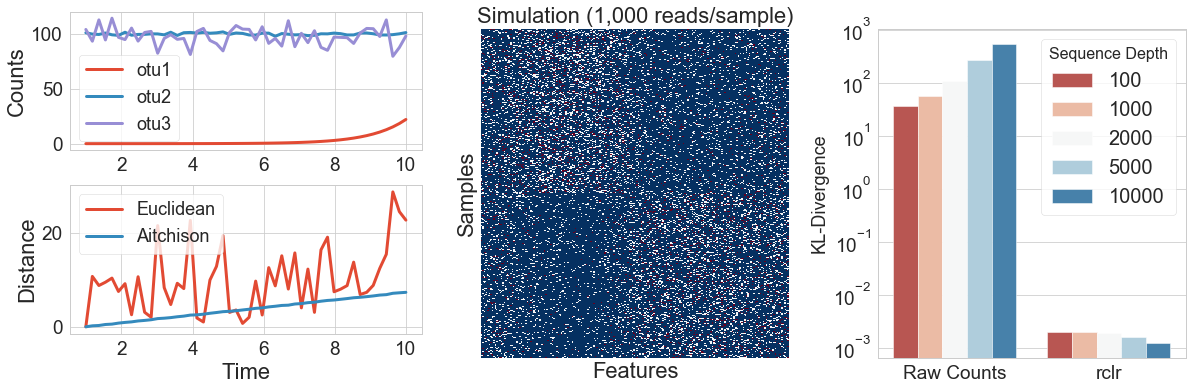

In [3]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(20, 7), facecolor='white')
gs = gridspec.GridSpec(110, 380)

ax_ex1=plt.subplot(gs[:40, :120])
ax_ex2=plt.subplot(gs[50:93, :120])
ax1=plt.subplot(gs[5:100, 140:245])
ax7=plt.subplot(gs[5:100, 275:])


ticksize=19
labelsize=22
ax_ex1.plot(t, x1, label='otu1',lw=3)
ax_ex1.plot(t, x2, label='otu2',lw=3)
ax_ex1.plot(t, x3, label='otu3',lw=3)
ax_ex1.legend() 
ax_ex1.set_ylabel('Counts', fontsize=labelsize)
ax_ex1.xaxis.set_tick_params(labelsize=ticksize)
ax_ex1.yaxis.set_tick_params(labelsize=ticksize)
ax_ex1.legend(prop={'size': 18})

ax_ex2.plot(t, edists, label='Euclidean',lw=3)
ax_ex2.plot(t, cdists, label='Aitchison',lw=3)
ax_ex2.xaxis.set_tick_params(labelsize=ticksize)
ax_ex2.yaxis.set_tick_params(labelsize=ticksize)
ax_ex2.legend()
ax_ex2.set_xlabel('Time', fontsize=labelsize)
ax_ex2.set_ylabel('Distance', fontsize=labelsize)
ax_ex2.legend(loc=2,prop={'size': 18})



sns.heatmap(model_100.as_matrix(),robust=True
            , xticklabels=False, yticklabels=False,
           cbar=False,cmap='RdBu_r',ax=ax1)
ax1.set_xlabel('Features',fontsize=22)
ax1.set_ylabel('Samples',fontsize=22)
ax1.set_title('Simulation (1,000 reads/sample)',fontsize=22)

ax7.tick_params(axis='both', which='major', labelsize=19)
sns.barplot(x='Proc',y='value',hue='Sequence_Depth'
            ,data=cluster_results_plot,ax=ax7
           ,palette='RdBu')
ax7.set_yscale('log')
ax7.set_xlabel('')
ax7.set_ylabel('KL-Divergence',fontsize=18)
legend=ax7.legend(prop={'size':20},title='Sequence Depth')
legend.get_title().set_fontsize(16)

plt.savefig('figures/figure2.png',dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
